## Введение

### Описание задачи

Предсказать следующие 10 MCC-кодов 7033 клиентов, основываясь на их предыдущих тратах. В качестве тренировочной выборки предоставлены последовательности MCC-кодов других 7033 клиентов с таргетом в виде 10 последующих MCC-кодов.

Целевая метрика — MAP@10 (mean average precision), обычно используется для оценки качества ранжирования, где задача стоит в сортировке уникальных айтемов по релевантности.

[Описание MCC-кодов.](https://mcc-codes.ru/code)

Данная задача представлена ALFABANK CAMPUS - [ссылка соревнования на Kaggle](https://www.kaggle.com/competitions/alfabank-campus)

### BaseLine

В [базовом решении](https://www.kaggle.com/code/prampampam/baseline-popular-transactions/notebook) представлено две функции:
1. топ10 MCC-кодов из train-части;
2. cамые популярные транзакции пользователя.

## EDA

### Библиотеки

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats
import seaborn as sns

from typing import List, Tuple

import logging
from logging import getLogger

from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.sequential_recommender import GRU4Rec
from recbole.trainer import Trainer
from recbole.utils import init_logger
from recbole.utils.case_study import full_sort_topk

### Метрики с Baseline

In [2]:
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

### Получение данных

In [3]:
df_train = pd.read_csv('df_train.csv', sep=';')
df_test = pd.read_csv('df_test.csv', sep=';')

In [4]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [5]:
df_train.head()

,Id,Data,Target
0,0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."
2,2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601..."
3,3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601..."
4,4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591..."


### Нахождение зависимостей

#### Корреляция между позицией MCC-кодов в Data и их позицией в целевой переменной Target

In [6]:
target_sequence = df_train['Target']

In [7]:
# Функция для расчета весов позиций в целевой переменной
def calculate_position_weights(target_sequence):
    weights = defaultdict(int)
    for sequence in target_sequence:
        for i, mcc_code in enumerate(sequence):
            weights[mcc_code] += i + 1  # Увеличиваем вес в зависимости от позиции
    return weights

In [8]:
position_weights = calculate_position_weights(target_sequence)

correlation_pearson = []
correlation_spearman = []

n_codes = 50 #кол-во последних элементов в Df.Train которые будут учитываться при рассчете корелляции

In [9]:
for i in range(len(df_train)):
    data_mcc = df_train.iloc[i]['Data'][:n_codes]  # Получение первых n_codes MCC-кодов из Data
    target_mcc = df_train.iloc[i]['Target']  # Список Target для каждой строки
    
    # Создание позиционных признаков для первых n_codes MCC-кодов из Data с использованием весов
    position_features = []
    for mcc in target_mcc:
        position = position_weights[mcc] if mcc in position_weights else -1
        position_features.append(position)
    
    # Расчет корреляции Пирсона и Спирмена для каждой пары MCC-кодов и весов
    pearson_corr, _ = pearsonr(position_features, range(len(position_features)))
    spearman_corr, _ = spearmanr(position_features, range(len(position_features)))
    
    # Добавление корреляции в список
    correlation_pearson.append(pearson_corr)
    correlation_spearman.append(spearman_corr)

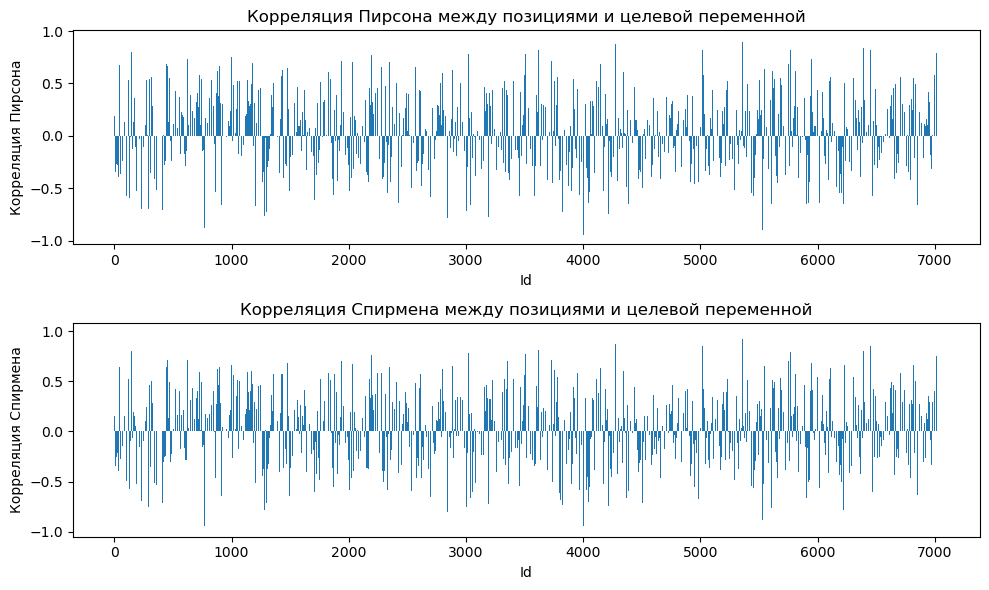

In [10]:
#Построение графиков корелляций
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(range(len(correlation_pearson)), correlation_pearson)
plt.title('Корреляция Пирсона между позициями и целевой переменной')
plt.xlabel('Id')
plt.ylabel('Корреляция Пирсона')

plt.subplot(2, 1, 2)
plt.bar(range(len(correlation_spearman)), correlation_spearman)
plt.title('Корреляция Спирмена между позициями и целевой переменной')
plt.xlabel('Id')
plt.ylabel('Корреляция Спирмена')

plt.tight_layout()
plt.show()

#### Распределение длин историй клиентов

(0.0, 1000.0)

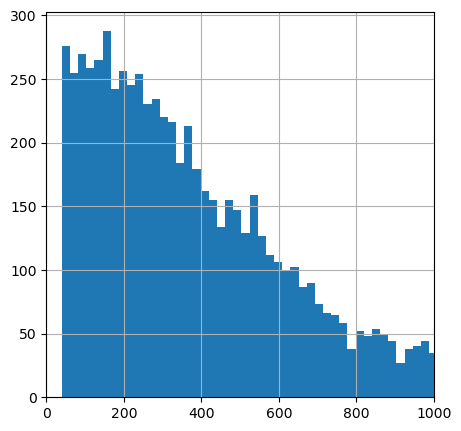

In [11]:
plt.figure(figsize=(8, 6), dpi=100)
df_train.Data.apply(len).hist(figsize = (5,5), bins = 1000)
plt.xlim(right=1000)
plt.xlim(left=0)

#### Нормальное ли распределение длин историй в train и в test

In [12]:
count_train_data = []
count_test_data = []

for client in df_train.Data:
  count_train_data.append(len(client))

for client in df_test.Data:
  count_test_data.append(len(client))
    
shapiro_train_test = stats.shapiro(count_test_data)
shapiro_train_train = stats.shapiro(count_train_data)
print(shapiro_train_test, shapiro_train_train)

ShapiroResult(statistic=0.12388652563095093, pvalue=0.0) ShapiroResult(statistic=0.3093855381011963, pvalue=0.0)


**Критерий Шапиро-Уилка** используется для проверки гипотезы **H0**: «случайная величина  **X** распределена нормально» и является одним наиболее эффективных критериев проверки нормальности. Смотрим на pvalue - это вероятность, при верности нулевой гипотезы, получить такое же значение наблюдаемой статистики или еще более экстремально. У нас pvalue = 0.0 => гипотеза отвергается.

## NO_ML Решение

Так как MCC коды расположены в хронологическом порядке и присутствует линейная зависимость между их позициями в Data и Target, то модель будет учитывать временной аспект транзакций, присваивая более высокий вес более поздним транзакциям в последовательности. Например, если у нас есть входная последовательность [1, 2, 2, 3, 3, 3, 3, 3], то выходная последовательность начнется с [3, 2, 1 ...]. Это связано с тем, что сумма позиций для кода '2' (2+3=5), для кода '1' (1), для кода '3' (4+5+6+7+8=30)"

In [13]:
total_top_10 = (df_train['Data'] + df_train['Target'] + df_test['Data']).explode().value_counts(ascending=False).index[:10]

# Определение максимальной длины последовательности транзакций
alpha = 2.1
sequence_length = int(np.mean([len(x) for x in df_test['Data']]) / alpha)

def top_codes_by_probability(seq, cutoff=sequence_length, drop_from=5):
    seq = seq[-cutoff:]
    seq_length = len(seq)
    # Расчет суммы всех индексов в последовательности кодов
    sum_of_positions = seq_length * (seq_length + 1) / 2
    probabilities = {}

    for code in np.unique(seq):
        # Определение позиций, на которых код встречается в последовательности
        positions = np.where(np.array(seq) == code)[0] + 1
        if len(positions) >= drop_from:
            # Вычисление вероятности кода для последовательности как отношение суммы его позиций к общей сумме всех индексов
            probabilities[code] = sum(positions) / sum_of_positions
    
    output = sorted(probabilities, key=probabilities.get, reverse=True)
    
    if len(output) < 10:
        # Добавление кодов из общего топ-10, если выходная последовательность содержит меньше 10 элементов
        output += [x for x in total_top_10 if x not in output]

    return output[:10]

# Применение функции для получения последовательности топ-10 кодов
no_ml_result = df_train['Data'].apply(top_codes_by_probability, drop_from=2)

# Вывод результата метрики mapk
print(mapk(df_train['Target'], no_ml_result))

0.3364563260727771


## Ml решение

[Научная статья](https://arxiv.org/abs/1511.06939) 2015-го года о *session-based recommendations*. В ней авторы предлагают использовать рекуррентные нейронные сети (*RNN*) с механизмом *GRU* (*gated recurrent unit*) для задачи рекомендаций.

Именно они изобрели модель *GRU4Rec*, ставшей повсеместным бейзлайном для последовательных рекомендаций (*sequential recommendations*). Эта модель будет использоваться для предсказания 10 наиболее вероятных следующих MCC-кодов клиента.

На [*paperswithcode*](https://paperswithcode.com/task/sequential-recommendation) описана реализация *GRU4Rec* в библиотеке [*RecBole*](https://recbole.io/docs/index.html).

#### Подготовка данных

Для обучения модели объединяем тренировочную и тестовую выборки. 
Объединяем столбцы `data` и `target` в тренировочном датасете:

In [14]:
train_data = df_train.apply(lambda row: row[1] + row[2], axis=1).reset_index()
test_data = df_test.copy()

In [15]:
train_data.columns = ['user_id', 'item_ids']
test_data.columns = ['user_id', 'item_ids']
display(train_data.head())
display(test_data.head())

,user_id,item_ids
0,0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481..."
1,1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481..."
2,2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601..."
3,3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569..."
4,4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481..."


,user_id,item_ids
0,0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481..."
1,1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601..."
2,2,"[4814, 6011, 5251, 6011, 7832, 5641, 5814, 482..."
3,3,"[6011, 4722, 4722, 4722, 4814, 6011, 6011, 482..."
4,4,"[4814, 4814, 4814, 6011, 4814, 4814, 4814, 481..."


Перед объединением присваиваем новые `user_id` клиентам из тренировочного датасета:

In [16]:
train_data['user_id'] = range(7033, 7033 * 2)
train_data.head()

,user_id,item_ids
0,7033,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481..."
1,7034,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481..."
2,7035,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601..."
3,7036,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569..."
4,7037,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481..."


Объединяем датафреймы в один для обучения модели и предсказаний:

In [17]:
full_train = pd.concat([test_data, train_data])

# Проверяем, что строк в новом датафрейме вдвое больше, чем в train
assert full_train.shape[0] == train_data.shape[0] * 2

display(full_train.head())
full_train.tail()

,user_id,item_ids
0,0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481..."
1,1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601..."
2,2,"[4814, 6011, 5251, 6011, 7832, 5641, 5814, 482..."
3,3,"[6011, 4722, 4722, 4722, 4814, 6011, 6011, 482..."
4,4,"[4814, 4814, 4814, 6011, 4814, 4814, 4814, 481..."


,user_id,item_ids
7028,14061,"[6010, 4829, 6011, 6011, 6011, 6010, 6011, 601..."
7029,14062,"[4814, 5699, 5641, 5411, 6010, 6011, 4814, 601..."
7030,14063,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 601..."
7031,14064,"[4814, 4814, 5411, 6011, 6011, 4814, 4814, 481..."
7032,14065,"[6011, 6011, 6011, 6011, 5541, 4814, 6011, 601..."


#### Форматирование данных для RecBole

Используемая библиотека *RecBole* принимает для обучения файлы определённого формата — [*Atomic*](https://recbole.io/docs/user_guide/data/atomic_files.html).  

Для примера в документации *RecBole* представлен сэмпл корректного форматирования популярного *RecSys* датасета `ml-100k` в формате *Atomic*.

In [18]:
file_path = \
'ml-100k\ml-100k.inter'
ml_100k = pd.read_csv(file_path, sep='\t')
ml_100k.head()

,user_id:token,item_id:token,rating:float,timestamp:float
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


То есть нужно будет развернуть данные по типу один `user_id` - одно наблюдение, а также добавить `timestamp` — последовательные рекомендательные модели типа GRU4Rec в библиотеке не работают без столбца со временем.

Условно разделяем транзакции по времени. У каждого клиента самая недавняя транзакция пусть будет в `timestamp` 150 000 000, а каждая предшествующая — по 6 часов (21 600 сек.) раньше:

In [19]:
origin = 150_000_0000
period = 21_600

def add_timestamp(arr: List[str]) -> List[Tuple[str, int]]:
    '''
    Функция принимает на вход последовательный список с MCC-кодами,
    возвращает список с кортежами (MCC-код, timestamp)
    '''
    new_arr_rev = []
    for i, elem in enumerate(reversed(arr)):
        new_arr_rev.append((elem, origin - (i * period)))
    return new_arr_rev[::-1]

In [20]:
full_train['item_timestamp'] = full_train['item_ids'].apply(add_timestamp)

In [21]:
full_train = full_train[['user_id', 'item_timestamp']]

Преобразуем датафрейм по типу одна транзакция - одна строка:

In [22]:
full_exploded = full_train.explode('item_timestamp').reset_index(drop=True)
full_exploded.head()

,user_id,item_timestamp
0,0,"(4814, 1495183200)"
1,0,"(4814, 1495204800)"
2,0,"(6011, 1495226400)"
3,0,"(6011, 1495248000)"
4,0,"(6010, 1495269600)"


Выделяем MCC-код и `timestamp` в отдельные столбцы:

In [23]:
full_exploded['item_id'] = \
full_exploded['item_timestamp'].apply(lambda arr: arr[0])

full_exploded['timestamp'] = \
full_exploded['item_timestamp'].apply(lambda arr: arr[1])

full_exploded = full_exploded.drop('item_timestamp', axis=1)

In [24]:
display(full_exploded.head())
full_exploded.shape

,user_id,item_id,timestamp
0,0,4814,1495183200
1,0,4814,1495204800
2,0,6011,1495226400
3,0,6011,1495248000
4,0,6010,1495269600


(6752236, 3)

Добавляем необходимую явную типизацию в названия колонок:

In [25]:
full_exploded.columns = ['user_id:token', 'item_id:token', 'timestamp:float']
display(full_exploded.head())
display(full_exploded.tail())

,user_id:token,item_id:token,timestamp:float
0,0,4814,1495183200
1,0,4814,1495204800
2,0,6011,1495226400
3,0,6011,1495248000
4,0,6010,1495269600


,user_id:token,item_id:token,timestamp:float
6752231,14065,5411,1499913600
6752232,14065,6011,1499935200
6752233,14065,5541,1499956800
6752234,14065,6010,1499978400
6752235,14065,4814,1500000000


Сохраняем получившийся файл для дальнейшего обучения.  
**RecBole**-у важно, чтобы данные для обучения лежали в одной папке, а сами файлы носили то же имя, что и папка, а также имели соответствующее типу данных расширение. У нас это `.inter` — файл с *interactions* `user_id` и `item_id`.

In [26]:
new_folder = 'full_train'

# Создаём новую папку 'full_train' если она не существует
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

new_csv = ('full_train/'
           + 'full_train.inter')

# Сохраняем csv с данными для обучения
if not os.path.exists(new_csv):
    full_exploded[['user_id:token', 'item_id:token', 'timestamp:float']]\
    .to_csv(new_csv, sep='\t', index=False)

#### Обучение модели

Диапазон подобранных гиперпараметров:

- `MAX_ITEM_LIST_LENGTH`: [20 - 150]
- `embedding_size`: [64 - 256]
- `hidden_size`: [64 - 256]
- `num_layers`: [1 - 3]
- `dropout_prob`: [0 - 0.5]
- `loss_type`: ['CE', 'BPR']
- `train_batch_size`: [256 - 7033]

В [оригинальной статье](https://arxiv.org/abs/1511.06939), представившей модель *GRU4Rec* авторы не используют эмбеддинги для айтемов (в их экспериментах *one-hot encoding* работал лучше), а также использовали функцию активации `tanh` для выходного слоя.

Пожалуй, наиболее важное различие — вместо *pointwise* кросс-энтропии авторы использовали *pairwis*e функции потерь *BPR* (*Bayesian Personalized Ranking*) и *TOP1*, опирающиеся на *negative sampling*.

In [27]:
# Для того чтобы тетрадка запускалась и на CPU, и на GPU
DEVICE = torch.device("cuda")
config_dict = {
    "USER_ID_FIELD": "user_id",
    "ITEM_ID_FIELD": "item_id",
    "TIME_FIELD": "timestamp",
    "load_col": {"inter": ["user_id", "item_id", "timestamp"]},
    "ITEM_LIST_LENGTH_FIELD": "item_length",
    "LIST_SUFFIX": "_list",
    "MAX_ITEM_LIST_LENGTH": 10,  # максимальная длина последовательности
    "embedding_size": 256, # размерность эмбеддингов
    "hidden_size": 10, # размерность скрытого состояния GRU
    "num_layers": 1,  # кол-во скрытых слоёв
    "dropout_prob": 0.3,  # droupout-вероятность в обучении
    "loss_type": "CE",  # функция потерь
    "epochs": 25,
    "train_batch_size": 300,
    "eval_batch_size": 4096,
    "train_neg_sample_args": None, # не используем negative sampling
    # словарь с параметрами валидации
    "eval_args": {
        "group_by": "user", # группируем по пользователям
        "order": "TO", # сортируем по timestamp-у
        "split": {"LS": "valid_only"}, # leave-one-out validation
        "mode": "full", # используем все данные для inference
    },
    "metrics": ["Recall", "MRR", "NDCG", "Hit", "Precision", "MAP"],
    "topk": 10,
    "valid_metric": "MAP@10", # валидационная метрика, также целевая метрика
    # соревнования
    "data_path": "",
    "stopping_step": 2, # останавливаем обучение если в течение
    # этого кол-ва эпох не было улучшения валидационной метрики
    "device": DEVICE,
}

In [28]:
config = Config(model='GRU4Rec', dataset='full_train', config_dict=config_dict)

# инициализируем логгеры для вывода информации
logger = getLogger()
logger.setLevel(logging.INFO)


c_handler = logging.StreamHandler()
c_handler.setLevel(logging.INFO)
logger.addHandler(c_handler)


logger.info(config)


General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = full_train
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 25
train_batch_size = 300
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 2
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'LS': 'valid_only'}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision', 'MAP']
topk = [10]
valid_metric = MAP@10
valid_metric_bigger = True
eval_batch_size = 4096
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = 	
seq

Создаём объекты тренировочной выборки и валдиацонной:

In [29]:
torch.cuda.empty_cache()

In [30]:
dataset = create_dataset(config)
logger.info(dataset)
train_data, valid_data, _ = data_preparation(config, dataset)

full_train
The number of users: 14067
Average actions of users: 480.0395279397128
The number of items: 185
Average actions of items: 36696.934782608696
The number of inters: 6752236
The sparsity of the dataset: -159.46237984625702%
Remain Fields: ['user_id', 'item_id', 'timestamp']
[Training]: train_batch_size = [300] train_neg_sample_args: [{'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}]
[Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'LS': 'valid_only'}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}]


Инициализируем модель и обучаем.

In [31]:
model = GRU4Rec(config, train_data.dataset).to(config['device'])
logger.info(model)

# инициализируем "тренера" модели
trainer = Trainer(config, model)

# сохраняем лучшие результаты
best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)

GRU4Rec(
  (item_embedding): Embedding(185, 256, padding_idx=0)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (gru_layers): GRU(256, 10, bias=False, batch_first=True)
  (dense): Linear(in_features=10, out_features=256, bias=True)
  (loss_fct): CrossEntropyLoss()
)
Trainable parameters: 58156
epoch 0 training [time: 1836.98s, train loss: 47811.6095]
epoch 0 evaluating [time: 0.15s, valid_score: 0.554300]
valid result: 
recall@10 : 0.9111    mrr@10 : 0.5543    ndcg@10 : 0.6413    hit@10 : 0.9111    precision@10 : 0.0911    map@10 : 0.5543
Saving current: saved\GRU4Rec-Feb-08-2024_21-05-39.pth
epoch 1 training [time: 1934.46s, train loss: 47448.6768]
epoch 1 evaluating [time: 0.15s, valid_score: 0.557400]
valid result: 
recall@10 : 0.9122    mrr@10 : 0.5574    ndcg@10 : 0.644    hit@10 : 0.9122    precision@10 : 0.0912    map@10 : 0.5574
Saving current: saved\GRU4Rec-Feb-08-2024_21-05-39.pth
epoch 2 training [time: 1957.94s, train loss: 47403.8846]
epoch 2 evaluating [time: 0.17s, vali

## Формируем ответ

Т.к использование RecBole не улучшило показатель основной метрики, ответ сформируем используя модель без ML подхода.

In [32]:
df_test['Predicted'] = df_test['Data'].apply(top_codes_by_probability, drop_from=2)

submission = df_test[['Id', 'Predicted']]
submission['Predicted'] = submission['Predicted'].apply(lambda x: str(x).replace(',', '')[1:-1])
submission.to_csv('output/submission_no_ml.csv', index=False)

![title](img/kaggle_result.jpg)